In [1]:
import mne
import signal_metrics
from pathlib import Path
import bids
import pickle
from eeg_fmri_cleaning import GradientRemover
import numpy as np
import os
import eeg_fmri_cleaning.main as cleaner

In [2]:
%%capture
def mne_metrics(filename, saving_pathname, folder = None):
    filename_entities = bids.layout.parse_file_entities(filename.name)

    if os.path.splitext(filename)[1] == '.set':
        raw = mne.io.read_raw_eeglab(filename, preload=True)
        channel_map = cleaner.map_channel_type(raw)
        raw = cleaner.set_channel_types(raw, channel_map)
    elif os.path.splitext(filename)[1] == '.fif':
        raw = mne.io.read_raw_fif(filename, preload=True)
        
    if filename_entities['task'] == 'checkeron':
        trigger_name = GradientRemover.extract_gradient_trigger_name(raw)
        annotations = raw.annotations
        index_grad_trigger = np.where(annotations.description == trigger_name)
        third_grad_trigger = annotations.onset[index_grad_trigger[0][1]]
        last_grad_trigger = annotations.onset[index_grad_trigger[0][-1]]
        
        raw.crop(tmin=third_grad_trigger, tmax=last_grad_trigger)
    
        raw_time_metrics = signal_metrics.SignalMetrics(raw)
        raw_time_metrics.calculate_time_metrics()

        noise_freq_tagging = signal_metrics.SignalMetrics(raw)
        noise_freq_tagging.calculate_frequency_metrics(frequency_range=(17,20),
                                                                    frequency_type="noise")
        ssvep_freq_tagging = signal_metrics.SignalMetrics(raw)
        ssvep_freq_tagging.calculate_frequency_metrics(frequency_range=(11,13),
                                                                    frequency_type="signal")
        try:
            ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
            epochs_ecg_metrics = signal_metrics.SignalMetrics(ecg_epochs)
            epochs_ecg_metrics.calculate_time_metrics()
        except:
            pass
        
        
        filename_path = Path(filename)
        base_filename =  os.path.splitext(filename_path)[0]
        
        for metric_object, metric_object_name in zip([raw_time_metrics, 
                                                    noise_freq_tagging, 
                                                    ssvep_freq_tagging], 
                                                    #epochs_ecg_metrics], 
                                                    ['raw_time_metrics', 
                                                    'noise_freq_tagging', 
                                                    'ssvep_freq_tagging',] 
                                                    ):

            saving_filename = "_".join([os.path.splitext(filename_path.name)[0],
                                        #folder,
                                    metric_object_name + '.pkl'])
            saving_full_filename = "/".join([saving_pathname,saving_filename])
            with open(saving_full_filename, 'wb') as f:
                pickle.dump(metric_object, f)
            print(f'{saving_full_filename} saved')




# CBIN-method metrics

In [3]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES')
folders = ['GRAD_BCG',
         'GRAD_BCG_ASR']
errors = {}
for folder in folders:
    child_path = path / folder
    for child_child_path in child_path.iterdir():
        for child_child_child_path in child_child_path.iterdir():
            eeg_path = child_child_child_path / 'eeg'
            for file in eeg_path.iterdir():
                if os.path.splitext(file)[1] == '.fif':
                    mne_metrics(file, path/'metrics', folder = folder)

# Brainvision metrics

In [4]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024/')
errors = {}
for file in path.iterdir():
    if os.path.splitext(file)[1] == '.set':
        filename_entities = bids.layout.parse_file_entities(file.name)
        if 'checker' in filename_entities['task']:
            try:
                mne_metrics(file)
            except Exception as e:
                errors[file] = e
                print(f'Error in {file}: {e}')
                continue

# EEGLAB metrics

In [3]:
%%capture
path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024')
saving_pathname = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method')
errors = {}
for child_child_path in path.iterdir():
    for child_child_child_path in child_child_path.iterdir():
        eeg_path = child_child_child_path / 'eeg'
        for file in eeg_path.iterdir():
            if os.path.splitext(file)[1] == '.set':
                try:
                    print(file)
                    mne_metrics(file, str(saving_pathname))
                except Exception as e:
                    errors[file] = e
                    print(f'Error in {file}: {e}')
                    continue

NotADirectoryError: [Errno 20] Not a directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_EEGLAB_2024/participants.tsv'

In [4]:
errors

{}

# Errors while reading eeglab files

In [5]:
errors

{PosixPath('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-15_ses-02_task-checker_run-01_eeg-edf.set'): RuntimeError('Incorrect number of samples (958464 != 8608000), please report this error to MNE-Python developers'),
 PosixPath('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-15_ses-01_task-checker_run-01_eeg-edf.set'): RuntimeError('Incorrect number of samples (524288 != 3760000), please report this error to MNE-Python developers'),
 PosixPath('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-03_ses-01_task-checker_run-01_eeg-edf_2.set'): RuntimeError('Incorrect number of samples (3162112 != 3840000), please report this error to MNE-Python developers'),
 PosixPath('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-14_ses-01_task-checker_run-01_eeg-edf.set'): RuntimeError('Incorrect number of samples (393216 != 4480000), please report this error to MNE-Python developers'),
 PosixPath('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-14_ses-02_task-checker_

# Time domain metrics

In [14]:
path_brainvision = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_bv_method')
path_sam = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
path_sam_asr = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_cbin_method')
eeglab_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method')

metrics = [
    'average_rms',
    'max_gradient',
    'zero_crossing_rate',
    'hjorth_mobility',
    'hjorth_complexity',
    'kurtosis',
    'skewness',
    'variance',
    'signal_range',
    'signal_iqr',
    ]

brainvision_metrics_dict = {
    metric: list() for metric in metrics
}

eeglab_metrics_dict = {
    metric: list() for metric in metrics
}

sam_metrics_dict = {
    metric: list() for metric in metrics
}

sam_asr_metrics_dict = {
    metric: list() for metric in metrics
}
error_log = dict()
subject_treated = list()

for file in path_brainvision.iterdir():
    if 'raw_time_metrics' not in file.name:
        continue
    subject = file.name[:6]
    file_brainvision = subject
    file_sam = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_raw_time_metrics.pkl'
    file_sam_asr = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_ASR_raw_time_metrics.pkl'
    file_eeglab = subject + '_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl'

    full_file_sam = path_sam / file_sam
    full_file_sam_asr = path_sam / file_sam_asr
    full_file_eeglab = eeglab_path / file_eeglab
    
    try:
        subject_treated.append(subject)
        #brain vision metrics
        process = 'brain_vision'
        file_process = file
        with open(file, 'rb') as f:
            brainvision_metrics = pickle.load(f)
            for metric in metrics:
                brainvision_metrics_dict[metric].append(getattr(brainvision_metrics,metric).flatten())
        process = 'eeglab'
        file_process = file_eeglab
        with open(full_file_eeglab, 'rb') as f:
            eeglab_metrics = pickle.load(f)
            for metric in metrics:
                eeglab_metrics_dict[metric].append(getattr(eeglab_metrics,metric).flatten())
        process = 'sam'
        file_process = full_file_sam
        #sam metrics
        with open(full_file_sam, 'rb') as f:
            sam_metrics = pickle.load(f)
            for metric in metrics:
                sam_metrics_dict[metric].append(getattr(sam_metrics,metric).flatten())
        process = 'sam_asr'
        file_process = full_file_sam_asr
        #sam asr metrics
        with open(full_file_sam_asr, 'rb') as f:
            sam_asr_metrics = pickle.load(f)
            for metric in metrics:
                sam_asr_metrics_dict[metric].append(getattr(sam_asr_metrics,metric).flatten())
        
        process = 'done'
    except Exception as e:
        error_log[subject] = f"{e} in {process} with file {file_process}"

for metric in metrics:
    brainvision_metrics_dict[metric] = np.concatenate(brainvision_metrics_dict[metric])
    sam_metrics_dict[metric] = np.concatenate(sam_metrics_dict[metric])
    sam_asr_metrics_dict[metric] = np.concatenate(sam_asr_metrics_dict[metric])
    eeglab_metrics_dict[metric] = np.concatenate(eeglab_metrics_dict[metric])

In [15]:
error_log

{'sub-12': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-12_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-12_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-08': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-08_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-08_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-02': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-02_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file sub-02_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl",
 'sub-20': "[Errno 2] No such file or directory: '/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics_eeglab_method/sub-20_ses-01_task-checkeron_run-01_eeg_raw_time_metrics.pkl' in eeglab with file

In [18]:
import seaborn
import matplotlib.pyplot as plt
def plot_time_metrics(brainvision_metrics_dict,
                      sam_metrics_dict,
                      sam_asr_metrics_dict,
                      eeglab_metrics_dict):
    metrics = [
        'average_rms',
        'max_gradient',
        'hjorth_mobility',
        'hjorth_complexity',
        'kurtosis',
        'skewness',
        'variance',
        'signal_range',
        'signal_iqr',
        #'snr_epochs'
        ]

    xlimits = {
    'average_rms': (0,0.001),
    'max_gradient': (0,0.002),
    'hjorth_mobility': (0,2),
    'hjorth_complexity': (1,5),
    'kurtosis': (-3,40),
    'skewness': (-6,6),
    'variance': (0,1e-7),
    'signal_range': (0,0.003),
    'signal_iqr': (0,0.0001),
    #'snr_epochs': (0,15)
    }



    fig, ax1 = plt.subplots(figsize = (20,10))
    ax1.spines[['right','left', 'top', 'bottom']].set_visible(False)
    ax1.set_yticks([])

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(2, 5, 1 + i)
        if i == 0:
            legend = True
        else:
            legend = False
        seaborn.kdeplot(data={'brainvision':brainvision_metrics_dict[metric],
                            'cbin':sam_metrics_dict[metric],
                            'cbin+asr':sam_asr_metrics_dict[metric],
                            'eeeglab':eeglab_metrics_dict[metric]},
                        x=None, 
                        y=None, 
                        hue=None, 
                        weights=None, 
                        palette=None, 
                        hue_order=None, 
                        hue_norm=None, 
                        color=None, 
                        fill=True, 
                        multiple='layer', 
                        common_norm=True, 
                        common_grid=False, 
                        cumulative=False, 
                        bw_method='scott', 
                        bw_adjust=1, 
                        warn_singular=True, 
                        log_scale=None, 
                        levels=10, 
                        thresh=0.05, 
                        gridsize=200, 
                        cut=3, 
                        clip=None, 
                        legend=legend, 
                        cbar=False, 
                        cbar_ax=None, 
                        cbar_kws=None, 
                        ax=ax)
        ax.spines[['top','right']].set_visible(False)
        plt.title(metric)
        plt.xlim(xlimits[metric])

In [19]:
plot_time_metrics(
    brainvision_metrics_dict,
    sam_metrics_dict,
    sam_asr_metrics_dict,
    eeglab_metrics_dict
    )

# Frequency domain metrics

In [27]:
path_brainvision = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/metrics_bv_method')
path_sam = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics')
path_sam_asr = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/metrics')
metrics = [
    'amplitude_peak_magnitude',
    'zscore_peak_magnitude',
    'snr_peak_magnitude'
    ]
brainvision_metrics_dict = {
    metric: list() for metric in metrics
}

sam_metrics_dict = {
    metric: list() for metric in metrics
}

sam_asr_metrics_dict = {
    metric: list() for metric in metrics
}
error_log = dict()
subject_treated = list()

for file in path_brainvision.iterdir():
    subject = file.name[:6]
    file_sam = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_ssvep_freq_tagging.pkl'
    file_sam_asr = subject + '_ses-01_task-checker_run-01_eeg_GRAD_BCG_ASR_ssvep_freq_tagging.pkl'

    full_file_sam = path_sam / file_sam
    full_file_sam_asr = path_sam / file_sam_asr
    
    try:
        if 'ssvep_freq_tagging' in file.name:
            subject_treated.append(subject)
            #brain vision metrics
            with open(file, 'rb') as f:
                brainvision_metrics = pickle.load(f)
                for metric in metrics:
                    brainvision_metrics_dict[metric].append(getattr(brainvision_metrics,metric).flatten())

            #sam metrics
            with open(full_file_sam, 'rb') as f:
                sam_metrics = pickle.load(f)
                for metric in metrics:
                    sam_metrics_dict[metric].append(getattr(sam_metrics,metric).flatten())

            #sam asr metrics
            with open(full_file_sam_asr, 'rb') as f:
                sam_asr_metrics = pickle.load(f)
                for metric in metrics:
                    sam_asr_metrics_dict[metric].append(getattr(sam_asr_metrics,metric).flatten())
    except Exception as e:
        error_log[subject] = e

for metric in metrics:
    brainvision_metrics_dict[metric] = np.concatenate(brainvision_metrics_dict[metric])
    sam_metrics_dict[metric] = np.concatenate(sam_metrics_dict[metric])
    sam_asr_metrics_dict[metric] = np.concatenate(sam_asr_metrics_dict[metric])

In [28]:
error_log

{'sub-16': FileNotFoundError(2, 'No such file or directory')}

In [6]:
brainvision_metrics.amplitude_peak_magnitude

array([8.61324890e-07, 1.07030820e-06, 9.56946615e-07, 6.61865200e-07,
       7.72870374e-07, 6.60623888e-07, 7.17152206e-07, 1.03808358e-06,
       6.97332277e-07, 1.34938016e-06, 1.10882346e-06, 1.03815041e-06,
       1.33605068e-06, 1.12220395e-06, 1.56214238e-06, 1.44511606e-06,
       1.71446458e-06, 8.02867457e-07, 1.42035127e-06, 1.27682018e-06,
       1.22613877e-06, 1.72723665e-06, 6.87191774e-07, 1.27096319e-06,
       1.73175472e-06, 8.67069007e-07, 4.92177481e-07, 9.04891864e-07,
       6.76612726e-07, 9.71787231e-07, 1.14910959e-06, 4.48955249e-07,
       9.16469140e-07, 6.28604085e-07, 6.07790577e-07, 5.78342264e-07,
       6.94559146e-07, 1.22175637e-06, 1.27771209e-06, 6.68112136e-07,
       9.09370829e-07, 9.69968415e-07, 9.62053126e-07, 1.08837496e-06,
       1.12823899e-06, 1.83602787e-06, 1.03985841e-06, 7.69643432e-06,
       3.25237740e-06, 2.13949127e-06, 7.18267721e-07, 7.07918736e-07,
       1.34255882e-06, 6.36707772e-07, 7.71207714e-07, 1.32972643e-06,
      

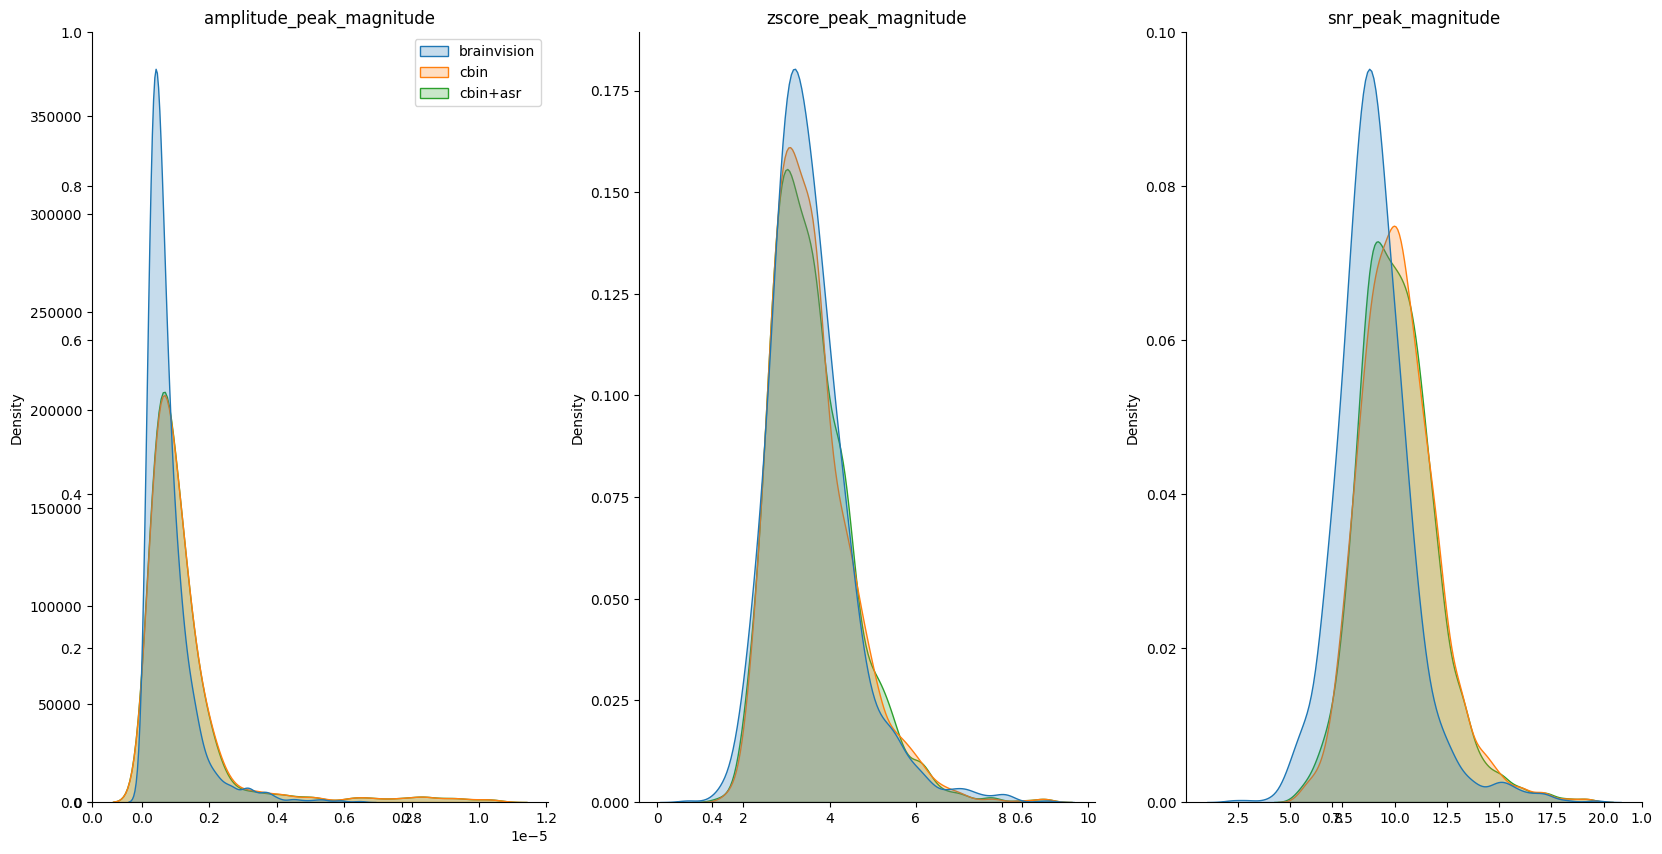

In [29]:

def plot_time_metrics(brainvision_metrics_dict,
                      sam_metrics_dict,
                      sam_asr_metrics_dict):
    metrics = [
        'amplitude_peak_magnitude',
        'zscore_peak_magnitude',
        'snr_peak_magnitude'
    ]

    fig, ax1 = plt.subplots(figsize = (20,10))
    ax1.spines[['right','left', 'top', 'bottom']].set_visible(False)

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(1, 3, 1 + i)
        if i == 0:
            legend = True
        else:
            legend = False
        seaborn.kdeplot(data={'brainvision':brainvision_metrics_dict[metric],
                            'cbin':sam_metrics_dict[metric],
                            'cbin+asr':sam_asr_metrics_dict[metric]},
                        x=None, 
                        y=None, 
                        hue=None, 
                        weights=None, 
                        palette=None, 
                        hue_order=None, 
                        hue_norm=None, 
                        color=None, 
                        fill=True, 
                        multiple='layer', 
                        common_norm=True, 
                        common_grid=False, 
                        cumulative=False, 
                        bw_method='scott', 
                        bw_adjust=1, 
                        warn_singular=True, 
                        log_scale=None, 
                        levels=10, 
                        thresh=0.05, 
                        gridsize=200, 
                        cut=3, 
                        clip=None, 
                        legend=legend, 
                        cbar=False, 
                        cbar_ax=None, 
                        cbar_kws=None, 
                        ax=ax)
        ax.spines[['top','right']].set_visible(False)
        plt.title(metric)
        #plt.xlim(xlimits[metric])
plot_time_metrics(brainvision_metrics_dict,
                  sam_metrics_dict,
                  sam_asr_metrics_dict)

TypeError: 'dict_items' object is not subscriptable

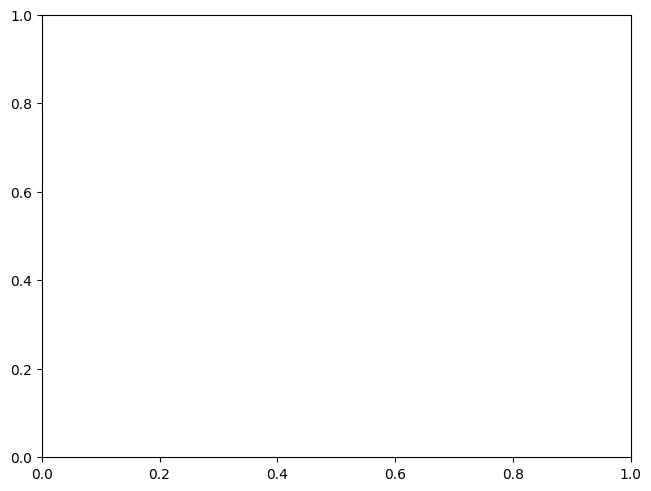

In [25]:
import matplotlib.pyplot as plt
import numpy as np

m_bv = list()
m_sam = list()
m_sam_asr = list()

std_bv = list()
std_sam = list()
std_sam_asr = list()

metrics = ("zscore_peak_magnitude", 
           "snr_peak_magnitude")
for metric in metrics:
    m_bv.append(np.mean(getattr(brainvision_metrics,metric)))
    m_sam.append(np.mean(getattr(sam_metrics,metric)))
    m_sam_asr.append(np.mean(getattr(sam_asr_metrics,metric)))
    
    std_bv.append(np.mean(getattr(brainvision_metrics,metric)))
    std_sam.append(np.mean(getattr(sam_metrics,metric)))
    std_sam_asr.append(np.mean(getattr(sam_asr_metrics,metric)))

methods = {
    'brainvision': m_bv,
    'c-bin': m_sam,
    'cbin + ASR': m_sam_asr,
}

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in methods.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2 = ax.twinx()
ax2
ax.set_ylabel('magnitude')
ax.set_title('peak magnitude')
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=3)

plt.show()

In [28]:
sam_metrics.__dir__()

['mne_object',
 'info',
 'amplitude',
 'amplitude_peak_magnitude',
 'amplitude_peak_frequency',
 'zscore',
 'zscore_peak_magnitude',
 'zscore_peak_frequency',
 'snr',
 'snr_peak_magnitude',
 'snr_peak_frequency',
 '__module__',
 '__doc__',
 '__init__',
 'calculate_frequency_metrics',
 'calculate_time_metrics',
 '__dict__',
 '__weakref__',
 '__slotnames__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

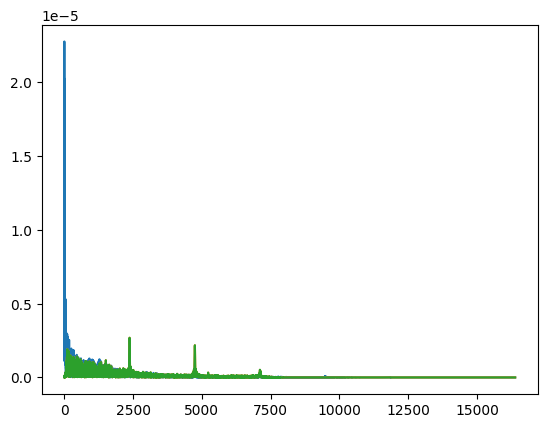

In [10]:
import matplotlib.pyplot as plt
plt.plot(brainvision_metrics.amplitude[0,1:])
plt.plot(sam_metrics.amplitude[0,:])
plt.plot(sam_asr_metrics.amplitude[0,:])

In [5]:
metric_path = path.joinpath('metrics', 'errors_log.pkl')
with open(metric_path, 'wb') as f:
    pickle.dump(errors, f)


In [69]:
f = bids.layout.BIDSFile('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/BCG/sub-22/ses-02/eeg/sub-22_ses-02_task-checkeroff_run-01_eeg.fif')

In [83]:
f = bids.layout.parse_file_entities(f.filename)

/home/slouviot/miniconda3/envs/mne/lib/python3.12/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [84]:
f

{'session': '02',
 'task': 'checkeroff',
 'run': 1,
 'suffix': 'eeg',
 'extension': 'fif'}

In [64]:
import os
filename_path = Path(filename)
base_filename =  os.path.splitext(filename_path)[0]
saving_filename = base_filename + '_metrics.pkl'

In [65]:
saving_filename

'/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/GRAD_BCG/sub-21/ses-01/eeg/sub-21_ses-01_task-checker_run-01_eeg_metrics.pkl'

In [12]:
ssvep_freq_tagging.snr_peak_frequency

array([11.98577881, 11.9934082 , 11.9934082 , 11.9934082 , 11.21520996,
       12.35961914, 11.21520996, 11.07788086, 11.19232178, 11.62719727,
       11.14654541, 11.08551025, 12.01629639, 11.08551025, 12.01629639,
       11.9934082 , 11.9934082 , 11.9934082 , 11.9934082 , 11.9934082 ,
       11.23046875, 11.03210449, 11.23046875, 11.10076904, 11.21520996,
       12.30621338, 11.21520996, 12.30621338, 11.97052002, 11.69586182,
       11.04736328, 11.03973389, 11.21520996, 11.51275635, 11.9934082 ,
       11.98577881, 11.9934082 , 12.0010376 , 12.71057129, 11.07025146,
       11.07788086, 11.08551025, 12.01629639, 11.9934082 , 11.06262207,
       11.03973389, 11.09313965, 11.03210449, 11.36016846, 11.61956787,
       12.86315918, 11.14654541, 12.1383667 , 12.71057129, 11.23046875,
       12.78686523, 11.9934082 , 12.2833252 , 12.93945312, 12.24517822,
       11.21520996, 11.29150391, 12.30621338, 11.08551025])

In [10]:
raw = mne.io.read_raw_eeglab('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-02_ses-01_task-checker_run-01_eeg-edf_2.set', preload=True)
def eeg_lab_metrics(raw):
    channel_map = cleaner.map_channel_type(raw)
    raw = cleaner.set_channel_types(raw, channel_map)

    raw_time_metrics = signal_metrics.SignalMetrics(raw)
    raw_time_metrics.calculate_time_metrics()

    noise_freq_tagging = signal_metrics.SignalMetrics(raw)
    noise_freq_tagging.calculate_frequency_metrics(frequency_range=(17,20),
                                                                frequency_type="noise")
    ssvep_freq_tagging = signal_metrics.SignalMetrics(raw)
    ssvep_freq_tagging.calculate_frequency_metrics(frequency_range=(11,13),
                                                                frequency_type="signal")
    ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
    epochs_ecg_metrics = signal_metrics.SignalMetrics(ecg_epochs)
    epochs_ecg_metrics.calculate_time_metrics()

Reading /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_2024/sub-02_ses-01_task-checker_run-01_eeg-edf_2.fdt
Reading 0 ... 66499  =      0.000 ...   265.996 secs...


<class 'mne.io.eeglab.eeglab.RawEEGLAB'>
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 218 (average pulse 49 / min.)
Not setting metadata
218 matching events found
No baseline correction applied
Using data from preloaded Raw for 218 events and 251 original time points ...
2 bad epochs dropped


/home/slouviot/01_projects/EEG_quality_assessment/src/EEG_quality_assessment/signal_metrics.py:111: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = self.mne_object.get_data()


In [19]:
trigger_name = GradientRemover.extract_gradient_trigger_name(raw)
gradient_trigger = mne.events_from_annotations(raw, event_id={trigger_name: 0})

Used Annotations descriptions: ['R128']


In [40]:
annotations.onset[2]

4.1

In [46]:
annotations.description

array(['Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On',
       'Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On',
       'Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On', 'Sync On',
       'Sync On', 'R128', 'Sync On', 'R', 'R128', 'S 11', 'S 12',
       'Sync On', 'R', 'S 11', 'R', 'S 11', 'S 12', 'R128', 'Sync On',
       'S 11', 'R', 'S 11', 'S 12', 'Sync On', 'S 11', 'R', 'S 11',
       'S 12', 'R128', 'Sync On', 'R', 'S 11', 'R', 'S 11', 'S 12',
       'R128', 'Sync On', 'S 11', 'S 11', 'S 12', 'Sync On', 'R128',
       'S 11', 'R', 'S 11', 'S 12', 'Sync On', 'R128', 'R', 'S 11',
       'condition 12', 'S 11', 'S 12', 'Sync On', 'TEND', 'R128', 'S 11',
       'R', 'S 11', 'S 12', 'R', 'Sync On', 'R128', 'S 11', 'R', 'S 11',
       'S 12', 'R', 'Sync On', 'R128', 'S 11', 'R', 'S 25', 'R',
       'Sync On', 'R128', 'S 26', 'R', 'S 26', 'S 27', 'R', 'Sync On',
       'S 26', 'R128', 'R', 'S 26', 'S 27', 'Sync On', 'R', 'S 26',
       'R128', 'R', 

In [47]:
import numpy as np

In [14]:
ev = mne.events_from_annotations(raw)

Used Annotations descriptions: ['R', 'R128', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99', 'Sync On', 'TEND', 'condition 12']


In [18]:
trigger_name

'R128'

# Time domaine metrics

- average_rms
- max_gradient
- zero_crossing_rate
- hjorth_mobility
- hjorth_complexity
- kurtosis
- skewness
- variance
- signal_range
- signal_iqr

# Frequency domain metrics
- amplitude
- snr
- zscore